In [169]:
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from scipy.misc import comb
import pandas as pd
import numpy as np
import trimesh
import glob
import math
import re

In [201]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [171]:
plt.rcParams["figure.figsize"] = [15,10]

In [172]:
import random

0.13756842764169971

In [222]:
def random_landmark(center =[0, 0, 0], circ = 10):
    r, theta = [math.sqrt(random.uniform(0, circ)) * math.sqrt(circ), 2 * math.pi * random.random()]
    x = center[0] + r * math.cos(theta)
    y = center[1] + r * math.sin(theta)
    return [x, y, center[2]]

In [174]:
def distance3D(a, b):
    return math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2+(a[2]-b[2])**2)

def distance2D(a, b):
        return math.sqrt( ((b[0]-a[0])**2)  + ((b[1]-a[1])**2) )
    
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

def lin_refine_implicit(x, n):
    """
    Given a 2D ndarray (npt, m) of npt coordinates in m dimension, insert 2**(n-1) additional points on each trajectory segment
    Returns an (npt*2**(n-1), m) ndarray
    """
    if n > 1:
        m = 0.5*(x[:-1] + x[1:])
        if x.ndim == 2:
            msize = (x.shape[0] + m.shape[0], x.shape[1])
        else:
            raise NotImplementedError

        x_new = np.empty(msize, dtype=x.dtype)
        x_new[0::2] = x
        x_new[1::2] = m
        return lin_refine_implicit(x_new, n-1)
    elif n == 1:
        return x
    else:
        raise ValueError

def vertex_correspondece(mesh, p_3D):
    distances = []
    for v in mesh.vertices:
        distances.append(distance3D(p_3D, v))
    distances = np.array(distances)
    return mesh.vertices[distances.argmin()]

In [175]:
torsos = glob.glob("/home/pablo/Dataset/dataset3D_CITES/torsos_reales/*.ply")

In [227]:
indi_values = []
values = []
temp_vertex = []
ids = []
for t in torsos[0:1]:
    mesh = trimesh.load(t)
    id_t = re.findall(r'\d+', t)[1]
    ids.append(id_t)
    print(t,id_t)
    landmarks_f = t.replace(".ply", ".pts")
    landmarks_f = landmarks_f.replace("torsos_reales", "landmarks_reales")
    landmarks = pd.read_csv(landmarks_f, header=None, index_col=[0], skiprows=range(2), delimiter=r"\s+")
    ls0 = landmarks.iloc[0].tolist()
    ls1 = landmarks.iloc[4].tolist()
    ls2 = landmarks.iloc[9].tolist()
    ls3 = landmarks.iloc[10].tolist()
    
    ls0 = random_landmark(center=ls0, circ= 0.05)
    ls1 = random_landmark(center=ls1, circ= 0.05)
    ls2 = random_landmark(center=ls2, circ= 0.05)
    ls3 = random_landmark(center=ls3, circ= 0.05)
    
    l_inferior = vertex_correspondece(mesh, np.array([ls1,ls2]).mean(0))
    l_superior = vertex_correspondece(mesh, np.array([ls0,ls3]).mean(0))
    dist_l = distance2D(l_inferior, l_superior)
    matrix_translate = [[1, 0, 0, 0],[0, 1, 0, dist_l / 100], [0, 0, 1, 0],[0, 0, 0, 1]]
    points = [None] * 100
    p = l_inferior
    for i in range(100):
        p = np.dot(matrix_translate, [p[0], p[1], p[2], 1])[:-1] 
        points[i] = vertex_correspondece(mesh, p)
        #sections[i] = mesh.section(plane_origin = vertex_correspondece(mesh, p) ,plane_normal = [0,1,0])    
    points = np.array(points)
    points = np.flip(points, axis=0)
    xvals, yvals = bezier_curve(points[:, [1, 2]], nTimes=500)
    sections = [None] * 250
    values = []
    temp_vertex = []
    for i in range(250):
        sections[i] = mesh.section(plane_origin = [l_inferior[0], xvals[i] , yvals[i]] ,plane_normal = [0,1,0])
        section_2D = sections[i].vertices[:,[0,2]]
        #section_2D, to_3D = sections[i].to_planar()
        vertexs_2d = section_2D
        mx = np.mean(vertexs_2d[:,0])
        my = np.mean(vertexs_2d[:,1])
        vertexs_2d = np.array(sorted(vertexs_2d, key=lambda x : (math.atan2(x[0] - mx, x[1] - my) + 2 * math.pi) % (2*math.pi)))
        xy = np.vstack((vertexs_2d[:,0], vertexs_2d[:,1])).T
        xy_highres_lin = lin_refine_implicit(xy, n=3)
        n=2712
        xy= xy.flatten()
        xy_highres_lin= xy_highres_lin.flatten()
        zro = np.zeros(n)
        zro[:xy.shape[0]] = xy
        zro = zro.reshape((zro.shape[0]//2),2)
        xy_highres_lin = xy_highres_lin.reshape((xy_highres_lin.shape[0]//2,2))
        zro[xy.shape[0]//2:n//2] = xy_highres_lin[np.random.randint(xy_highres_lin.shape[0],size=abs(n//2 - xy.shape[0]//2))]
        mx = np.mean(zro[:,0])
        my = np.mean(zro[:,1])
        vertexs_2d = np.array(sorted(zro, key=lambda x : (math.atan2(x[0] - mx, x[1] - my) + 2 * math.pi) % (2*math.pi)))
        temp_vertex.append(vertexs_2d)
        values.append(np.array(vertexs_2d).flatten())
    indi_values.append(np.array(values).flatten())
    #plt.axes().set_aspect('equal', 'datalim')
    #plt.plot(xvals, yvals,".")
    #plt.plot(sections[:, 1], sections[:, 2], ".")
    

/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_009.ply 009


/home/pablo/.miniconda3/envs/fetas_3D/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  if sys.path[0] == '':


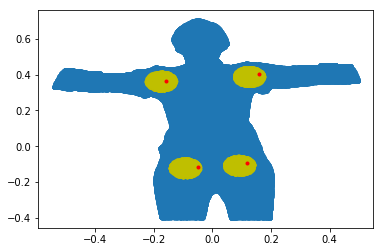

In [228]:
plt.plot(mesh.vertices[:,0], mesh.vertices[:,1], "." )
plt.plot(landmarks.iloc[0].tolist()[0],landmarks.iloc[0].tolist()[1],".r")
plt.plot(landmarks.iloc[4].tolist()[0],landmarks.iloc[4].tolist()[1],".r")
plt.plot(landmarks.iloc[9].tolist()[0],landmarks.iloc[9].tolist()[1],".r")
plt.plot(landmarks.iloc[10].tolist()[0],landmarks.iloc[10].tolist()[1],".r")

for i in range(2000):
    aux = random_landmark(center=landmarks.iloc[0].tolist(), circ= .05)
    plt.plot(aux[0],
             aux[1], ".y")
    
for i in range(2000):
    aux = random_landmark(center=landmarks.iloc[4].tolist(), circ= .05)
    plt.plot(aux[0],
             aux[1], ".y")
    
for i in range(2000):
    aux = random_landmark(center=landmarks.iloc[9].tolist(), circ= .05)
    plt.plot(aux[0],
             aux[1], ".y")

for i in range(2000):
    aux = random_landmark(center=landmarks.iloc[10].tolist(), circ= .05)
    plt.plot(aux[0],
             aux[1], ".y")
plt.plot(ls0[0],ls0[1],".r")
plt.plot(ls1[0],ls1[1],".r")
plt.plot(ls2[0],ls2[1],".r")
plt.plot(ls3[0],ls3[1],".r")

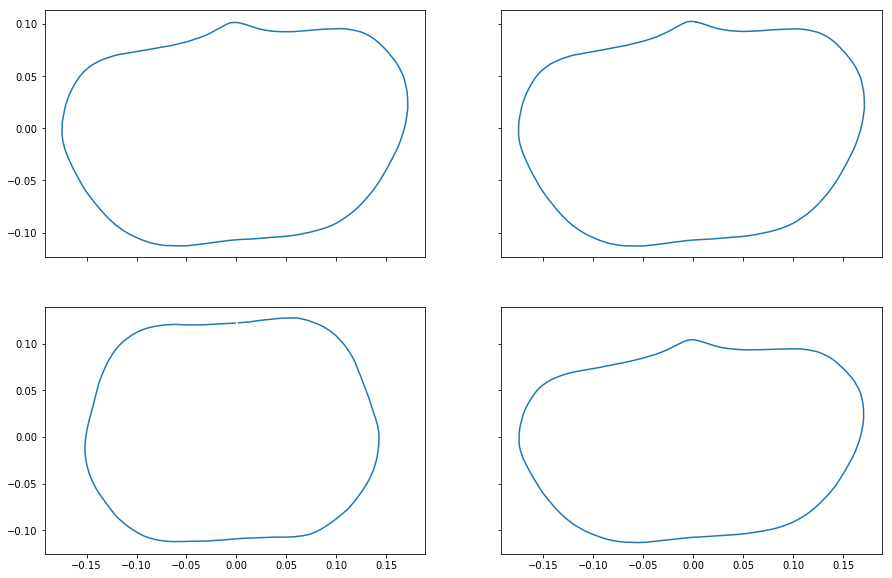

In [181]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(temp_vertex[0][:,0],temp_vertex[0][:,1],"-")

ax2.plot(temp_vertex[1][:,0],temp_vertex[1][:,1],"-")

ax3.plot(temp_vertex[-1][:,0],temp_vertex[-1][:,1],"-")

ax4.plot(temp_vertex[3][:,0],temp_vertex[3][:,1],"-")

plt.show()

In [7]:
from scipy.spatial import procrustes

In [8]:
indi_values = np.array(indi_values)
indi_values = indi_values.reshape(-1,indi_values.shape[1]//2,2)
pcentro = indi_values.mean(0)
procrusteados = []
for p1 in indi_values:
    mtx1,mtx2, disparity = procrustes(pcentro,p1)
    procrusteados.append(mtx2)


In [9]:
np.shape(procrusteados)

(113, 339000, 2)

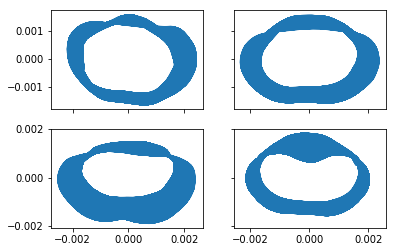

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(procrusteados[0][:,0],procrusteados[0][:,1],"-")
#ax1.set_title("id="+ids[0])
ax2.plot(procrusteados[5][:,0],procrusteados[5][:,1],"-")
#ax2.set_title("id="+ids[5])
ax3.plot(procrusteados[6][:,0],procrusteados[6][:,1],"-")
#ax3.set_title("id="+ids[6])
ax4.plot(procrusteados[-1][:,0],procrusteados[-1][:,1],"-")
#ax4.set_title("id="+ids[-1])

In [11]:
np.save("procrustes_r", procrusteados)

In [12]:
np.save("procrustes_files_r", torsos)

In [13]:
np.save("procrustes_id_r", list(map(lambda x: re.findall(r'\d+', x)[1], torsos)))

In [14]:
list(map(lambda x: re.findall(r'\d+', x)[1], torsos))

['009',
 '147',
 '145',
 '149',
 '042',
 '070',
 '081',
 '092',
 '002',
 '071',
 '084',
 '086',
 '135',
 '117',
 '024',
 '103',
 '141',
 '130',
 '107',
 '058',
 '080',
 '055',
 '038',
 '125',
 '018',
 '091',
 '106',
 '153',
 '047',
 '041',
 '033',
 '097',
 '030',
 '089',
 '146',
 '094',
 '006',
 '142',
 '139',
 '035',
 '051',
 '087',
 '121',
 '028',
 '064',
 '079',
 '067',
 '049',
 '048',
 '046',
 '113',
 '100',
 '045',
 '143',
 '151',
 '127',
 '104',
 '061',
 '021',
 '059',
 '150',
 '148',
 '050',
 '138',
 '098',
 '090',
 '115',
 '054',
 '011',
 '073',
 '085',
 '053',
 '019',
 '069',
 '015',
 '118',
 '044',
 '105',
 '005',
 '026',
 '110',
 '154',
 '082',
 '124',
 '004',
 '078',
 '012',
 '016',
 '074',
 '114',
 '025',
 '001',
 '036',
 '052',
 '075',
 '034',
 '039',
 '112',
 '123',
 '137',
 '120',
 '088',
 '128',
 '013',
 '101',
 '020',
 '017',
 '063',
 '065',
 '122',
 '136',
 '056',
 '043']

In [15]:
torsos

['/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_009.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_147.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_145.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_149.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_042.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_070.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_081.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_092.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_002.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_071.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_084.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_086.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales/model_mesh_135.ply',
 '/home/pablo/Dataset/dataset3D_CITES/torsos_reales